<a href="https://colab.research.google.com/github/rombab/TradingBot/blob/main/Strategy_TQQQ_or_not_optimis%C3%A9e_pour_scheduling_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General Section for installing the core libraries**

In [ ]:
%%capture
pip install yfinance

In [ ]:
%%capture
!pip install alpaca-trade-api

In [ ]:
%%capture
!pip install alpaca-py
!pip install alpaca
!pip install pandas

In [ ]:
%%capture
!pip install backtrader
!pip install alpaca_trade_api
!pip install matplotlib==3.2.2
!pip install plotly

In [ ]:
pip install yfinance ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=17c3590a24627fb94bd51b3e66d8b884d6a6f8fcdc47f823087cd857bb080f9a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
pip install pytz

In [ ]:
pip install alpha_vantage

In [ ]:
pip install python-telegram-bot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.9/604.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00


# **Old shared functions (for trading and backtesting)**

For reference see simple project - Back-Test All Weather portfolio from Alpaca web page
https://alpaca.markets/learn/google-colab-instant-development-environments/



Shared functions:

*   Alpaca API definition (paper trading)
*   calculate_quantity(weight, trading_balance, price):
*   adjust_position_to_target_quantity(symbol, weight, trading_balance):
*   get_market_data(symbol, days, timeframe):
*   calculate_moving_average(data, window):
*   calculate_rsi(data, periods):
*   calculate_cumulative_return(data):
*   calculate_max_drawdown(data):



In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from alpaca_trade_api import REST, TimeFrame
from alpaca_trade_api.rest import APIError
from alpaca_trade_api.stream import Stream
from datetime import datetime, timedelta


# Set up Alpaca API
api_key = 'AKFCM53MJBHLFV8Y8DM1'
api_secret = 'pEsFbBhk8qAev3qVsuO8hDt5bMGF5kJqAQrcRxhD'
rest_api_backtesting = REST(api_key, api_secret, 'https://paper-api.alpaca.markets')
alpaca_api_trading = REST(api_key, api_secret, 'https://paper-api.alpaca.markets')
alpaca_api_market_data = REST(api_key, api_secret, 'https://paper-api.alpaca.markets')


# Define a function to calculate the quantity for orders
def calculate_quantity(weight, trading_balance, price):
    # This function will calculate the number of shares to order based on the portfolio balance and desired weight.
    qty= int((trading_balance * (weight / 100)) // price)
    print('Calculated order quantity: Weight ' , weight, ' Trading balance: ' , trading_balance , ' Price: ', price, ' Trading quantity :', qty)
    return qty


def adjust_position_to_target_weight(symbol, weight, trading_balance):
    # Initialize qty_difference
    qty_difference = 0

    # Find price and target quantity
    last_days = get_market_data(symbol, 7, '1Day' )
    price =last_days['close'].iloc[-1] #if using alpca API for market data
    #price = get_market_data(symbol, '1d' , '1d')['Adj Close'].iloc[-1] #if using yahoo  API for market data

    target_qty = calculate_quantity(weight, trading_balance, price)
    print('Target position, quantity ', target_qty, ' shares of instrument symbol', symbol, 'that has market price', price , ' Total Value: ', target_qty*price )
    print(f"Target position for {symbol}: {target_qty} shares.")

    # Check the current position
    try:
        # Try to find the current position
        position = alpaca_api_trading.get_position(symbol)
        current_qty = int(position.qty)
        print(f"Current position for {symbol}: {current_qty} shares.")

        # Calculate the difference current/target
        qty_difference = target_qty - current_qty

    except APIError as e:
        # If there is no current postision
        if 'position does not exist' in str(e):
            if target_qty > 0:
                   # If no position exists and target quantity is more than 0, buy the target quantity
                   print(f"No current position for {symbol}. Buying {target_qty} shares to open a position.")
                   qty_difference = target_qty
            else:
                   print(f"No current position for {symbol}. And {target_qty} shares  for target position. Position matches the target quantity.")
        else:
            # Handle other possible API errors
            print(f"An error occurred: {e}")

    # Now, let's try to submit an order and catch a possible 422 error
    try:
        if qty_difference != 0:
            if qty_difference > 0:
                print(f"Buying {qty_difference} more shares of {symbol} to match the target quantity.")
            elif qty_difference < 0:
                print(f"Selling {-qty_difference} shares of {symbol} to match the target quantity.")

     # the algo is typically rebalancing the portfolio for tiny orders (1-2 shares) on a daily basis
     # this is shitty cause will create transaction costs the day I use something else than Alpaca (ex Avanza)
     # a threshold should be introduced to limit small rebalancing creating transaction costs for 1-2 shares
     # maybe don't buy/sell unless the transaction price is < 2% of your order total value?

            alpaca_api_trading.submit_order(
                symbol=symbol,
                qty=abs(qty_difference),  # Make sure the quantity is positive
                side='buy' if qty_difference > 0 else 'sell',
                type='market',
                time_in_force='gtc'
            )
        else:
            print(f"No action required for {symbol}. Position matches the target quantity.")

    except APIError as e:
        print(f"An error occurred when submitting the order: {e}")
        if e.status_code == 422:
            # This is where you'd handle the 'unprocessable entity' error
            print(f"Unprocessable Entity: Check if the order details are correct. Symbol: {symbol}, Qty: {abs(qty_difference)}, Side: {'buy' if qty_difference > 0 else 'sell'}")



# Function to get market data from Alpaca
def get_market_data(symbol, days, timeframe):
    # Calculate the start date based on the period
    days = int(days) #ensure that days is an integer
    end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    start_date = end_date - timedelta(days=days)

    # Format dates in RFC-3339 format, removing microseconds
    start_date = start_date.replace(microsecond=0).isoformat() + 'Z'  # Append 'Z' to indicate UTC
    end_date = end_date.replace(microsecond=0).isoformat() + 'Z'

    # Retrieve the data
    barset = alpaca_api_market_data.get_bars(symbol, timeframe, start=start_date, end=end_date, limit=1000).df
    return barset

# Function to get market data from Yahoo
def get_market_data_yahoo(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    return data


# Function to calculate Moving Average, for the window (typically 14)
def calculate_moving_average(data, window):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    return data['close'].rolling(window=window).mean()

# Function to calculate Relative Strength Indicator (RSI), for the number of periods (typically 14)
def calculate_rsi(data, periods):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

# Function to calculate Cumulative Return
def calculate_cumulative_return(data):
   return (data['Adj Close'].iloc[-1] / data['Adj Close'].iloc[0] - 1) # to be used if Yahoo for market data
   #return (data['close'].iloc[-1] / data['close'].iloc[0] - 1) # to be used if Alpaca for market data

# Function to calculate maximum drawdown
def calculate_max_drawdown(data):
    # Convert the data to a pandas DataFrame if it's not already
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Calculate the running maximum
    # running_max = data['Adj Close'].cummax() # to be used if Yahoo for market data
    running_max = data['close'].cummax() # to be used if Alpaca for market data

    # Calculate drawdowns
    # drawdowns = (data['Adj Close'] - running_max) / running_max # to be used if Yahoo for market data
    drawdowns = (data['close'] - running_max) / running_max # to be used if Alpaca for market data

    # The Maximum Drawdown is the minimum drawdown (since drawdowns are negative)
    max_drawdown = drawdowns.min()
    return max_drawdown

# Function to calculate the volatility over a period (typically 45d)
def calculate_volatility(symbol, days, timeframe='1Day'):
    market_data = get_market_data(symbol, days, timeframe)
    daily_returns = market_data['close'].pct_change().dropna()
    volatility = daily_returns.std()
    return volatility

# Function to set the weighting of a portfolio inverted to the volatility (so the most volatile weights the least).
def set_inverse_volatility_weights(symbols):
    volatilities = {}
    inverse_vol_weights = {}

    # Calculate 45d volatilities
    for symbol, _ in symbols:
        volatilities[symbol] = calculate_volatility(symbol, 45)

    # Calculate inverse volatilities
    for symbol in volatilities:
        inverse_vol_weights[symbol] = 1 / volatilities[symbol] if volatilities[symbol] != 0 else 0

    # Normalize weights so they sum to 1 (or 100%)
    total_inverse_vol = sum(inverse_vol_weights.values())
    normalized_weights = {symbol: (weight / total_inverse_vol) * 100 for symbol, weight in inverse_vol_weights.items()}

    # Create the output in the desired format
    output_weights = [(symbol, weight) for symbol, weight in normalized_weights.items()]
    print(output_weights)
    return output_weights


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
#just a tiny piece of code to test the weighting function
portfolio_symbols = [('IEF', 25), ('UUP', 25), ('GLD', 25), ('TMF', 25)]
new_weights = set_inverse_volatility_weights(portfolio_symbols)
print(new_weights)

[('IEF', 29.095168740873774), ('UUP', 41.956482661262164), ('GLD', 24.149241464887364), ('TMF', 4.799107132976681)]
[('IEF', 29.095168740873774), ('UUP', 41.956482661262164), ('GLD', 24.149241464887364), ('TMF', 4.799107132976681)]


# **Backtesting Shared functions, also including the function that sends an order to paper trading**

## Prerequisites for Back Testing

### Set-Up Alpca API

In [ ]:
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.stream import Stream

# Set up Alpaca API
api_key = 'PKBUVP5ORDE7CAR0BH1C'
api_secret = 'midTkk0u9BLQeyWBtFYkEhUH1iBqxmgUXc8zirAK'
rest_api_backtesting = REST(api_key, api_secret, 'https://paper-api.alpaca.markets')

In [ ]:
# retrieve daily bar data for SPY in a dataframe
spy_bars = rest_api_backtesting.get_bars('SPY', TimeFrame.Day, '2021-01-01', '2021-03-30').df
spy_bars.head(3)

# quote and trade data also available for equities
# spy_quotes = rest_api.get_quotes('SPY', '2021-01-01', '2021-01-05').df
# spy_trades = rest_api.get_trades('SPY', '2021-01-01', '2021-01-05').df

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-04 05:00:00+00:00,368.97,375.45,364.82,623066,375.31,111804895,369.329637
2021-01-05 05:00:00+00:00,371.40,372.50,368.05,338929,368.10,67456696,370.404421
2021-01-06 05:00:00+00:00,373.41,376.98,369.12,575346,369.71,109080743,373.804762


## Set-Up Telegram API

In [ ]:
import asyncio
from telegram import Bot

# Replace 'YOUR_TOKEN' with the API token you got from BotFather
TOKEN = '6852918032:AAGYWF9OCSP4cSudS7eim7y0SpV462Kop3c'
chat_id = 5112146878


In [ ]:
# Define a function to calculate the quantity for orders
def send_message_telegram(text):

    async def send_message(token, chat_id, message):
           bot = Bot(token=TOKEN)
           await bot.send_message(chat_id=chat_id, text=text)

    # Get the current event loop and run the coroutine within it
    loop = asyncio.get_event_loop()
    task = loop.create_task(send_message(TOKEN, chat_id, text))


## Runbacktest function (the core of the back testing)

In [ ]:
from datetime import datetime, timedelta
import backtrader as bt
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


mpl.rcParams['figure.dpi'] = 140 # chart resolution

def run_backtest(strategy, symbols, start, end, timeframe=TimeFrame.Day, cash=10000):
    '''params:
        strategy: the strategy you wish to backtest, an instance of backtrader.Strategy
        symbols: the symbol (str) or list of symbols List[str] you wish to backtest on
        start: start date of backtest in format 'YYYY-MM-DD'
        end: end date of backtest in format: 'YYYY-MM-DD'
        timeframe: the timeframe the strategy trades on (size of bars) -
                   1 min: TimeFrame.Minute, 1 day: TimeFrame.Day, 5 min: TimeFrame(5, TimeFrameUnit.Minute)
        cash: the starting cash of backtest
    '''

    if isinstance(end, str):
            # Convert to datetime object
            end_date_obj = datetime.fromisoformat(end.rstrip('Z'))

            # Convert back to a string in the desired format 'YYYY-MM-DD'
            end_date_formatted = end_date_obj.strftime('%Y-%m-%d')

    else:
            end_date_formatted = end

    # initialize backtrader broker
    cerebro = bt.Cerebro(stdstats=True,cheat_on_open=False)
    #cerebro = bt.Cerebro(stdstats=True,cheat_on_open=True)
    cerebro.broker.set_cash(cash)
    # add strategy
    cerebro.addstrategy(strategy, end_date = end_date_formatted )
    #cerebro.addstrategy(strategy)

    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')



    # historical data request
    if type(symbols) == str:
        symbol = symbols
        alpaca_data = rest_api_backtesting.get_bars(symbol, timeframe, start, end,  adjustment='all').df
        data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
        cerebro.adddata(data)
    elif type(symbols) == list or type(symbols) == set:
        for symbol in symbols:
            alpaca_data = rest_api_backtesting.get_bars(symbol, timeframe, start, end, adjustment='all').df
            data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
            cerebro.adddata(data)

    # To only plot the portfolio value and buy/sell points, disable all other plots
    for data in cerebro.datas:
        data.plotinfo.plot = False


    # run
    initial_portfolio_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {initial_portfolio_value}')
    results = cerebro.run()

    strat = results[0]

    # Print final values with rounding
    final_portfolio_value = round(cerebro.broker.getvalue(), 2)
    return_percentage = round((final_portfolio_value/initial_portfolio_value - 1) * 100, 2)
    sharpe_ratio = round(strat.analyzers.mysharpe.get_analysis()['sharperatio'], 2)

    print(f'Final Portfolio Value: {final_portfolio_value} ---> Return: {return_percentage}%')
    print(f'Sharpe Ratio: {sharpe_ratio}')





    # Display the summary of trades with rounded numbers
    print("Trade Summary:")
    for trade in strat.trade_list:
        print(f"Date: {trade['date']}, "
              f"Symbol: {trade['symbol']}, "
              f"Type: {trade['order_type']}, "
              f"Size: {trade['size']}, "
              f"Price: {round(trade['price'], 2)}, "
              f"Value: {round(trade['value'], 2)}, "
              #f"Commission: {round(trade['commission'], 2)}, "
              #f"PnL: {round(trade['pnl'], 2) if trade['pnl'] is not None else 'n/a'}"
              )


    # Comment out the Backtrader plot if you're going to use custom Matplotlib plots
    #cerebro.plot(iplot=False)  # iplot=False is for Jupyter notebook. Remove it if you run the script from a Python file.






    # Add another subplot for the portfolio value
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))  # Adjust the size as needed


    # Since we don't know the lengths beforehand, we'll access the full arrays
    # We need to convert the line buffer to a list for plotting
    rsi_values = list(strat.rsi_10_day_tqqq.array)
    soxs_prices = list(strat.data_dict['SOXS'].close.array)
    tqqq_price_values = list(strat.data_dict['TQQQ'].close.array)

    # Use the minimum length of the two series to synchronize the plotting data
    min_length = min(len(rsi_values), len(soxs_prices), len (tqqq_price_values))


    # Generate a list of x values representing the time series
    x_values = list(range(min_length))

    # Plot 1: Price of TQQQ and Price of SOXS
    #axs[0].plot(x_values, rsi_values[:min_length], label='RSI TQQQ (10-day)')
    #axs[0].plot(x_values, soxs_prices[:min_length], label='Price SOXS')
    axs[0].plot(x_values, tqqq_price_values[:min_length], label='Price TQQQ')
    axs[0].axhline(79, color='red', linestyle='--')  # Threshold line
    axs[0].legend()
    axs[0].set_title("TQQQ and SOXS Price")


    # Retrieve the full data series for the second plot
    qqq_close_values = list(strat.data_dict['QQQ'].close.array)
    sma_25_qqq_values = list(strat.sma_25_qqq.array)


    # Determine the minimum length for the second plot data series
    min_length_2 = min(len(qqq_close_values), len(sma_25_qqq_values))

    # Generate a list of x values representing the time series for the second plot
    x_values_2 = list(range(min_length_2))

    # Plot 2: QQQ Close and SMA alongside TQQQ Price
    axs[1].plot(x_values_2, qqq_close_values[:min_length_2], label='QQQ Close')
    axs[1].plot(x_values_2, sma_25_qqq_values[:min_length_2], label='SMA 25 QQQ')

    axs[1].legend()
    axs[1].set_title("QQQ Close, SMA 25 QQQ")


    # Extract the portfolio values. Since we want all values, we provide the index -1
    #portfolio_values = strat.observers.value.get(0)

    # Plot 3: Portfolio Value Over Time
    portfolio_values = list(strat.observers.value.get(0, size=len(strat)))
    x_values_portfolio = list(range(len(portfolio_values)))
    axs[2].plot(portfolio_values, label='Portfolio Value')
    axs[2].legend()
    axs[2].set_title("Portfolio Value Over Time")

    plt.tight_layout()
    plt.show()


## Shared functions I built for backtesting



### Diverse small things

In [ ]:
def log(self, txt, dt=None):
        ''' Logging function '''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')


In [ ]:
'''
from alpha_vantage.timeseries import TimeSeries

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key.
ALPHA_VANTAGE_API_KEY = 'YOUR_API_KEY'

def fetch_closing_data_from_alpha_vantage(symbol, start_date, end_date):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')

    # Fetch the daily adjusted closing prices
    data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize='full')

    # Filter the data for the date range and only keep the adjusted close column
    data = data[(data.index >= start_date) & (data.index <= end_date)]['5. adjusted close']

    return data

# Example usage
closing_data = fetch_closing_data_from_alpha_vantage('AAPL', '2022-01-01', '2022-12-31')
print(closing_data)
'''

"\nfrom alpha_vantage.timeseries import TimeSeries\n\n# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key.\nALPHA_VANTAGE_API_KEY = 'YOUR_API_KEY'\n\ndef fetch_closing_data_from_alpha_vantage(symbol, start_date, end_date):\n    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')\n\n    # Fetch the daily adjusted closing prices\n    data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize='full')\n\n    # Filter the data for the date range and only keep the adjusted close column\n    data = data[(data.index >= start_date) & (data.index <= end_date)]['5. adjusted close']\n\n    return data\n\n# Example usage\nclosing_data = fetch_closing_data_from_alpha_vantage('AAPL', '2022-01-01', '2022-12-31')\nprint(closing_data)\n"

### Custom Indicators (probably no longer needed)

In [ ]:
class LogReturn(bt.Indicator):
            lines = ('logreturn',)

            params = (
                 ('period', 1),
            )

            def __init__(self):
                  self.addminperiod(self.params.period + 1)

            def next(self):
                  price_today = self.data[0]
                  price_prev = self.data[-self.params.period]
                  self.lines.logreturn[0] = math.log(price_today / price_prev)



class InverseVolatility(bt.Indicator):
    lines = ('inverse_vol',)
    params = (('period', 45),)

    def __init__(self):
        self.addminperiod(self.params.period)
        self.volatility = bt.indicators.StandardDeviation(self.data, period=self.params.period)

    def next(self):
        self.lines.inverse_vol[0] = 1.0 / self.volatility[0] if self.volatility[0] != 0 else 0


In [ ]:
   # Get market data with yahoo
    #bnd_data = get_market_data_yahoo('BND', '60d', '1d')
    #bil_data = get_market_data_yahoo('BIL', '60d', '1d')
    #qqq_data = get_market_data_yahoo('QQQ', '10d', '1d')
    #svxy_data = get_market_data_yahoo('SVXY', '5d', '1d')
    #bnd_recent_data = get_market_data_yahoo('BND', '2d', '1d')


In [ ]:
from pandas import Timestamp
import pytz

def fetch_closedata_from_alpaca(symbol, start_date, end_date):
    # Initialize the Alpaca API connection

    # Convert start and end dates to timestamps with timezone
    eastern = pytz.timezone('US/Eastern')
    start_timestamp = Timestamp(start_date, tz=eastern).isoformat()
    end_timestamp = Timestamp(end_date, tz=eastern).isoformat()

    # Fetch the barset (price data) from Alpaca
    barset = rest_api_backtesting.get_bars(symbol, '1D', start=start_timestamp, end=end_timestamp).df

    # Alpaca returns data in a MultiIndex DataFrame, we want to select the 'close' column for our symbol
    data = barset['close']

    return data


# Example usage
data = fetch_closedata_from_alpaca('TQQQ', '2023-10-01', '2023-11-19')
print(data)


timestamp
2023-10-02 04:00:00+00:00    36.47
2023-10-03 04:00:00+00:00    34.54
2023-10-04 04:00:00+00:00    35.94
2023-10-05 04:00:00+00:00    35.56
2023-10-06 04:00:00+00:00    37.35
2023-10-09 04:00:00+00:00    37.90
2023-10-10 04:00:00+00:00    38.52
2023-10-11 04:00:00+00:00    39.34
2023-10-12 04:00:00+00:00    38.88
2023-10-13 04:00:00+00:00    37.41
2023-10-16 04:00:00+00:00    38.67
2023-10-17 04:00:00+00:00    38.30
2023-10-18 04:00:00+00:00    36.68
2023-10-19 04:00:00+00:00    35.70
2023-10-20 04:00:00+00:00    34.09
2023-10-23 04:00:00+00:00    34.39
2023-10-24 04:00:00+00:00    35.36
2023-10-25 04:00:00+00:00    32.77
2023-10-26 04:00:00+00:00    30.86
2023-10-27 04:00:00+00:00    31.30
2023-10-30 04:00:00+00:00    32.31
2023-10-31 04:00:00+00:00    32.78
2023-11-01 04:00:00+00:00    34.47
2023-11-02 04:00:00+00:00    36.30
2023-11-03 04:00:00+00:00    37.58
2023-11-06 05:00:00+00:00    38.01
2023-11-07 05:00:00+00:00    39.08
2023-11-08 05:00:00+00:00    39.15
2023-11-09

In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


def PeriodStartDate(NumberOfDaysForPeriod, EndDate):
    # Define US business day calendar which excludes weekends and US federal holidays
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    # Convert EndDate to a pandas datetime object
    end_date = pd.to_datetime(EndDate)

    # Calculate the start date by subtracting business days
    start_date = end_date - NumberOfDaysForPeriod * us_bd

    # Format the start date in YYYY-MM-DD format
    start_date_formatted = start_date.strftime('%Y-%m-%d')

    return start_date_formatted


# Example usage
start_date = PeriodStartDate(5, '2023-12-26')
print(start_date)


2023-12-18


In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

def CumulativeReturn(InstrumentSymbol, NumberOfDaysForPeriod, AsOfDate):
    # Convert AsOfDate to a datetime object
    end_date = datetime.strptime(AsOfDate, "%Y-%m-%d")
    # Calculate the start date
    start_date = end_date - timedelta(days=NumberOfDaysForPeriod)

    data = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    # Debugging code
    #datay = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    #dataa = fetch_closedata_from_alpaca(InstrumentSymbol, start_date, end_date)
    # Check if we have enough data
    if len(data) < 2:
        return "Not enough data for the given period."

    # Debugging code
    # Get the starting and final closing prices
    #starting_price_yahoo = datay['Close'].iloc[0]
    #final_price_yahoo = datay['Close'].iloc[-1]
    #starting_price_alpaca = dataa.iloc[0]
    #final_price_alpaca = dataa.iloc[-1]
    #print(starting_price_yahoo)
    #print(starting_price_alpaca)
    #print(final_price_yahoo)
    #print(final_price_alpaca)
    starting_price = data['Close'].iloc[0]
    final_price = data['Close'].iloc[-1]


    # Calculate cumulative return
    cumulative_return = (final_price - starting_price) / starting_price * 100

    return cumulative_return

# Example usage
cumulative_return = CumulativeReturn('TQQQ', 4, '2023-11-20')
print(cumulative_return)


[*********************100%%**********************]  1 of 1 completed

0.06955432078357224


In [ ]:
import yfinance as yf
import pandas as pd
import ta
from ta.momentum import RSIIndicator

def RelativeStrengthIndex(InstrumentSymbol, NumberOfDaysForPeriod, AsOfDate):


    # Calculate the start date
    start_date = PeriodStartDate(NumberOfDaysForPeriod+5, AsOfDate)

    # Convert Start_date and end_dates to dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(AsOfDate)

    # Fetch historical data from Yahoo Finance / Alpaca
    data = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    #data = fetch_closedata_from_alpaca(InstrumentSymbol, start_date, end_date)

    # Calculate RSI
    rsi_indicator = RSIIndicator(data['Close'], window=NumberOfDaysForPeriod)
    #rsi_indicator = RSIIndicator(data, window=NumberOfDaysForPeriod)
    data['RSI'] = rsi_indicator.rsi()

    # Get the RSI for the latest date
    latest_rsi = data['RSI'].iloc[-1]

    return latest_rsi

# Example usage
rsi_value = RelativeStrengthIndex('TQQQ', 20, '2023-04-25')
print(rsi_value)


[*********************100%%**********************]  1 of 1 completed

50.78095377103926


In [ ]:
import yfinance as yf
import numpy as np

def AnnualizedStandardDeviation(InstrumentSymbol, NumberOfDaysForPeriod, AsOfDate):

    # Calculate the start date
    start_date = PeriodStartDate(NumberOfDaysForPeriod, AsOfDate)

    # Convert Start_date and end_dates to dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(AsOfDate)

    # Fetch historical data from Yahoo Finance / Alpaca
    data = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    #data = fetch_closedata_from_alpaca(InstrumentSymbol, start_date, end_date)

    # Compute daily percent returns
    daily_returns = data['Close'].pct_change().dropna()
    #daily_returns = data.pct_change().dropna()

    # Calculate standard deviation of daily returns
    std_dev = np.std(daily_returns)

    # Annualize the standard deviation
    annualized_std_dev = std_dev * np.sqrt(252)

    return annualized_std_dev

# Example usage
annualized_std_dev = AnnualizedStandardDeviation('AAPL', 60, '2023-01-31')
print(annualized_std_dev)


[*********************100%%**********************]  1 of 1 completed

0.3583528808731374


In [ ]:
import yfinance as yf

def MaxDrawdown(InstrumentSymbol, NumberOfDaysForPeriod, AsOfDate):

    # Calculate the start date
    start_date = PeriodStartDate(NumberOfDaysForPeriod, AsOfDate)

    # Convert Start_date and end_dates to dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(AsOfDate)

    # Fetch historical data from Yahoo Finance / Alpaca
    data = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    #data = fetch_closedata_from_alpaca(InstrumentSymbol, start_date, end_date)


    # Compute max drawdown
    max_drawdown = 0
    peak = data['Close'].iloc[0]
    #peak = data.iloc[0]

    for price in data['Close']:
    #for price in data:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown * 100  # Convert to percentage

# Example usage
max_drawdown = MaxDrawdown('TQQQ', 6, '2023-04-25')
print(max_drawdown)


[*********************100%%**********************]  1 of 1 completed

2.943318894685941


In [ ]:
import yfinance as yf
import pandas as pd

def SMA(InstrumentSymbol, NumberOfDaysForPeriod, AsOfDate):

    # Calculate the start date
    start_date = PeriodStartDate(NumberOfDaysForPeriod, AsOfDate)

    # Convert Start_date and end_dates to dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(AsOfDate)

    # Fetch historical data from Yahoo Finance / Alpaca
    data = yf.download(InstrumentSymbol, start=start_date, end=end_date)
    #data = fetch_closedata_from_alpaca(InstrumentSymbol, start_date, end_date)

    # Calculate Simple Moving Average
    sma = data['Close'].rolling(window=NumberOfDaysForPeriod).mean().iloc[-1]
    #sma = data.rolling(window=NumberOfDaysForPeriod).mean().iloc[-1]

    return sma

# Example usage
sma_value = SMA('AAPL', 10, '2023-01-31')
print(sma_value)


[*********************100%%**********************]  1 of 1 completed

140.26800079345702


## Rebalance portfolio

In [ ]:
# Define a function to calculate the quantity for orders
def calculate_quantity(weight, trading_balance, price):
    # This function will calculate the number of shares to order based on the portfolio balance and desired weight.
    qty= int((trading_balance * (weight / 100)) // price)
    print('Calculated order quantity: Weight ' , weight, ' Trading balance: ' , trading_balance , ' Price: ', price, ' Trading quantity :', qty)
    return qty


def adjust_position_to_target_weight(symbol, weight, trading_balance):
    # Initialize qty_difference
    qty_difference = 0

    # Find price and target quantity
    last_days = get_market_data(symbol, 7, '1Day' )
    price =last_days['close'].iloc[-1] #if using alpca API for market data
    #price = get_market_data(symbol, '1d' , '1d')['Adj Close'].iloc[-1] #if using yahoo  API for market data

    target_qty = calculate_quantity(weight, trading_balance, price)
    print('Target position, quantity ', target_qty, ' shares of instrument symbol', symbol, 'that has market price', price , ' Total Value: ', target_qty*price )
    print(f"Target position for {symbol}: {target_qty} shares.")

    # Check the current position
    try:
        # Try to find the current position
        position = alpaca_api_trading.get_position(symbol)
        current_qty = int(position.qty)
        print(f"Current position for {symbol}: {current_qty} shares.")

        # Calculate the difference current/target
        qty_difference = target_qty - current_qty

    except APIError as e:
        # If there is no current postision
        if 'position does not exist' in str(e):
            if target_qty > 0:
                   # If no position exists and target quantity is more than 0, buy the target quantity
                   print(f"No current position for {symbol}. Buying {target_qty} shares to open a position.")
                   qty_difference = target_qty
            else:
                   print(f"No current position for {symbol}. And {target_qty} shares  for target position. Position matches the target quantity.")
        else:
            # Handle other possible API errors
            print(f"An error occurred: {e}")

    # Now, let's try to submit an order and catch a possible 422 error
    try:
        if qty_difference != 0:
            if qty_difference > 0:
                print(f"Buying {qty_difference} more shares of {symbol} to match the target quantity.")
            elif qty_difference < 0:
                print(f"Selling {-qty_difference} shares of {symbol} to match the target quantity.")

     # the algo is typically rebalancing the portfolio for tiny orders (1-2 shares) on a daily basis
     # this is shitty cause will create transaction costs the day I use something else than Alpaca (ex Avanza)
     # a threshold should be introduced to limit small rebalancing creating transaction costs for 1-2 shares
     # maybe don't buy/sell unless the transaction price is < 2% of your order total value?

            alpaca_api_trading.submit_order(
                symbol=symbol,
                qty=abs(qty_difference),  # Make sure the quantity is positive
                side='buy' if qty_difference > 0 else 'sell',
                type='market',
                time_in_force='gtc'
            )
        else:
            print(f"No action required for {symbol}. Position matches the target quantity.")

    except APIError as e:
        print(f"An error occurred when submitting the order: {e}")
        if e.status_code == 422:
            # This is where you'd handle the 'unprocessable entity' error
            print(f"Unprocessable Entity: Check if the order details are correct. Symbol: {symbol}, Qty: {abs(qty_difference)}, Side: {'buy' if qty_difference > 0 else 'sell'}")


In [ ]:
def rebalance_portfolio_old(self, target_weights):
        # Get the total value of the portfolio
        total_value = self.broker.getvalue()

        # Create a dictionary with the current value and number of shares of each position
        positions_value = {symbol: self.getposition(data).size * data.close[0]
                       for symbol, data in self.data_dict.items()}
        positions_shares = {symbol: int(self.getposition(data).size)
                       for symbol, data in self.data_dict.items()}

        # Rebalance each asset in the portfolio
        for symbol, target_weight in target_weights.items():

            target_value = total_value * target_weight
            current_value = positions_value.get(symbol, 0)  # Use get to avoid KeyError
            current_shares = positions_shares.get(symbol, 0)  # Use get to avoid KeyError
            difference_value = target_value - current_value
            self.log(f'Position of {symbol} is {current_shares} shares, worth today at {self.data_dict[symbol].close[0]:.2f} per share for a total value of {current_value:.2f}')


            # Determine if we need to buy or sell
            if difference_value > 0:
                # Buy if the target value is greater than the current value
                size_to_buy = int(difference_value / self.data_dict[symbol].close[0])
                order = self.buy(data=self.data_dict[symbol], size=size_to_buy)     # The actual logging will be done in notify_trade when the trade is executed
                # Log the transaction details
                self.log(f'Buying {size_to_buy} shares of {symbol} at {self.data_dict[symbol].close[0]:.2f} per share for a total value of {difference_value:.2f}')

            elif difference_value < 0:
                # Sell if the target value is less than the current value
                size_to_sell = int(-difference_value / self.data_dict[symbol].close[0])
                order = self.close(data=self.data_dict[symbol], size=size_to_sell)     # The actual logging will be done in notify_trade when the trade is executed
                # Log the transaction details
                self.log(f'Selling {size_to_sell} shares of {symbol} at {self.data_dict[symbol].close[0]:.2f} per share for a total value of {-difference_value:.2f}')





In [ ]:
def rebalance_portfolio(self, target_weights):
    # Get the total value of the portfolio
    total_value = self.broker.getvalue()

    # Create a dictionary with the current value and number of shares of each position
    positions_value = {symbol: self.getposition(data).size * data.close[0]
                       for symbol, data in self.data_dict.items()}
    positions_shares = {symbol: int(self.getposition(data).size)
                        for symbol, data in self.data_dict.items()}

    # First scan for sells
    for symbol, target_weight in target_weights.items():
        target_value = total_value * target_weight
        current_value = positions_value.get(symbol, 0)
        difference_value = target_value - current_value

        # Sell if the target value is less than the current value
        if difference_value < 0:
            size_to_sell = int(-difference_value / self.data_dict[symbol].close[0])
            order = self.close(data=self.data_dict[symbol], size=size_to_sell)
            self.log(f'Selling {size_to_sell} shares of {symbol} at {self.data_dict[symbol].close[0]:.2f} per share for a total value of {-difference_value:.2f}')

    # Then scan for buys
    for symbol, target_weight in target_weights.items():
        target_value = total_value * target_weight
        current_value = positions_value.get(symbol, 0)
        difference_value = target_value - current_value

        # Buy if the target value is greater than the current value
        if difference_value > 0:
            size_to_buy = int(difference_value / self.data_dict[symbol].close[0])
            order = self.buy(data=self.data_dict[symbol], size=size_to_buy)
            self.log(f'Buying {size_to_buy} shares of {symbol} at {self.data_dict[symbol].close[0]:.2f} per share for a total value of {difference_value:.2f}')


In [ ]:
def cancel_all_open_orders_paper(self):
    try:
        rest_api_backtesting.cancel_all_orders()
        self.log("PAPER TRADE - All open orders cancelled successfully")
        send_message_telegram("PAPER TRADE - All open orders cancelled successfully")
    except APIError as e:
        self.log(f"Error cancelling orders: {e}")
        send_message_telegram(f"Error cancelling orders: {e}")


In [ ]:
def rebalance_portfolio_paper(self, target_weights):
        # Cancel all open orders before rebalancing
        cancel_all_open_orders_paper(self)

        # Get the total value of the portfolio from Alpaca
        account = rest_api_backtesting.get_account()
        total_value = float(account.equity)

        # Create a dictionary with the current value and number of shares of each position
        positions_value = {}
        positions_shares = {}
        positions_price = {}
        for symbol, target_weight in target_weights.items():
            try:
                position = rest_api_backtesting.get_position(symbol)
                current_qty = int(position.qty)
                quote = rest_api_backtesting.get_latest_trade(symbol)
                current_price = float(quote.price)
                positions_value[symbol] = current_qty * current_price
                positions_shares[symbol] = current_qty
                positions_price[symbol] = current_price

            except APIError:
                # Handle the case where there is no position for the symbol
                positions_value[symbol] = 0
                positions_shares[symbol] = 0
                quote = rest_api_backtesting.get_latest_trade(symbol)
                positions_price[symbol] = float(quote.price)
            self.log(f'PAPER TRADE - Position of {symbol}, {positions_shares[symbol]} shares at a unit price of {positions_price[symbol]:.2f} per share for a total value of {positions_value[symbol]:.2f}')
            send_message_telegram(f'PAPER TRADE - Position of {symbol}, {positions_shares[symbol]} shares at a unit price of {positions_price[symbol]:.2f} per share for a total value of {positions_value[symbol]:.2f}')
        # Rebalance each asset in the portfolio
        for symbol, target_weight in target_weights.items():
            target_value = total_value * target_weight
            current_value = positions_value[symbol]
            current_shares = positions_shares[symbol]
            difference_value = target_value - current_value
            self.log(f'PAPER TRADE - Position of {symbol}, {positions_shares[symbol]} has total value of {positions_value[symbol]:.2f}, while target value is {target_value:.2f}, difference value is {difference_value:.2f}')
            send_message_telegram(f'PAPER TRADE - Position of {symbol}, {positions_shares[symbol]} has total value of {positions_value[symbol]:.2f}, while target value is {target_value:.2f}, difference value is {difference_value:.2f}')

            # Determine if we need to buy or sell
            if difference_value > 0:
                # Calculate the size to buy
                size_to_buy = int(difference_value / positions_price[symbol] *0.98) # Buying 98% of the actual cash position in the paper account just to avoid errors in execution (as I cannot seem to get the current market price and I want to avoid the error "insufficient buying power".)
                value_to_buy = size_to_buy*positions_price[symbol]
                if size_to_buy > 0:
                    self.log(f'PAPER TRADE - Buying {size_to_buy} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {value_to_buy:.2f}')
                    send_message_telegram(f'PAPER TRADE - Buying {size_to_buy} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {value_to_buy:.2f}')
                    # Submit a buy order to Alpaca
                    rest_api_backtesting.submit_order(
                        symbol=symbol,
                        qty=size_to_buy,
                        side='buy',
                        type='market',
                        time_in_force='gtc'
                    )
                else:
                    self.log(f'PAPER TRADE - Order is too small, skiping to do a Buying {size_to_buy} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {difference_value:.2f}')
                    send_message_telegram(f'PAPER TRADE - Order is too small, skiping to do a Buying {size_to_buy} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {difference_value:.2f}')

            elif difference_value < 0:
                # Calculate the size to sell
                size_to_sell = min(current_shares, int(-difference_value / positions_price[symbol]))
                value_to_sell = size_to_sell*positions_price[symbol]
                if size_to_sell > 0:
                    self.log(f'PAPER TRADE - Selling {size_to_sell} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {value_to_sell:.2f}')
                    send_message_telegram(f'PAPER TRADE - Selling {size_to_sell} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {value_to_sell:.2f}')
                    # Submit a sell order to Alpaca
                    rest_api_backtesting.submit_order(
                        symbol=symbol,
                        qty=size_to_sell,
                        side='sell',
                        type='market',
                        time_in_force='gtc'
                    )
                else:
                    self.log(f'PAPER TRADE - Order is too small, skiping to do a Selling {size_to_sell} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {-difference_value:.2f}')
                    send_message_telegram(f'PAPER TRADE - Order is too small, skiping to do a Selling {size_to_sell} shares of {symbol} at {positions_price[symbol]:.2f} per share for a total value of {-difference_value:.2f}')
            elif difference_value == 0:
                self.log(f'PAPER TRADE - current position of {symbol} which has a last  price of {positions_price[symbol]:.2f} matches the target position, no trade is sent')
                send_message_telegram(f'PAPER TRADE - current position of {symbol} which has a last  price of {positions_price[symbol]:.2f} matches the target position, no trade is sent')

In [ ]:
def check_if_paper_trade(self,weights_set_one):
        # Get the current backtest datetime
        current_date = self.datas[0].datetime.date(0)


        # Parse the end_date string into a datetime object
        end_date_obj = datetime.strptime(self.params.end_date, '%Y-%m-%d').date()

        # Check if end_date is a Monday
        if end_date_obj.weekday() == 0:  # where Monday is 0 and Sunday is 6
            # If it's Monday, subtract 3 days
            test_date = end_date_obj - timedelta(days=3)
        else:
            # If it's not Monday, subtract 1 day
            test_date = end_date_obj - timedelta(days=1)

        if current_date == test_date:
           #if current_date == datetime.strptime(self.params.end_date, '%Y-%m-%d').date():
                self.log(f'Today is the end date {test_date}. Calling rebalance_portfolio_paper')
                rebalance_portfolio_paper(self,weights_set_one)
        else:
                self.log(f'Current date of {current_date} does not match {test_date} , no need to call the rebalance portfolio paper')


# **Strategy Definition - TQQQ or not, rebuilt as per the start**


Link to the strategy https://app.composer.trade/symphony/YVqpvgFviyxCuIPB0gyW/details


In [ ]:
class TQQQ_or_not(bt.Strategy):

  # list of parameters which are configurable for the strategy
    params = (

        ('start_date', None),  # Add a start date parameter
        ('end_date', None),  # Add an end date parameter
    )

    def __init__(self):

        # Convert string start_date to datetime object
        if isinstance(self.params.start_date, str):
            self.start_date = datetime.strptime(self.params.start_date, '%Y-%m-%d').date()
        else:
            self.start_date = self.params.start_date

        # Convert string start_date to datetime object
        if isinstance(self.params.end_date, str):
            self.end_date = datetime.strptime(self.params.end_date, '%Y-%m-%d').date()
        else:
            self.end_date = self.params.end_date

        # Initialize indicators and variables
        # Assuming symbols in the following order 'SOXS' , 'TQQQ', 'UVXY', 'BIL', 'BND', 'QQQ', 'SPY', 'IEF', 'TMF', 'TLT'  added to cerebro
        self.soxs = self.datas[0]
        self.tqqq = self.datas[1]
        self.uvxy = self.datas[2]
        self.bil = self.datas[3]
        self.bnd = self.datas[4]
        self.qqq = self.datas[5]
        self.spy = self.datas[6]
        self.ief = self.datas[7]
        self.tmf = self.datas[8]
        self.tlt = self.datas[9]

        # Initialize the data dictionary for the symbols
        self.data_dict = {
            'SOXS': self.soxs,
            'TQQQ': self.tqqq,
            'UVXY': self.uvxy,
            'BIL': self.bil,
            'BND': self.bnd ,
            'QQQ': self.qqq ,
            'SPY': self.spy ,
            'IEF': self.ief ,
            'TMF': self.tmf ,
            'TLT': self.tlt
        }

        # Initialize the weights dictionary
        self.weights = {
            'SOXS': 0,
            'TQQQ': 0,
            'BIL' : 0,
            'UVXY': 0,
            # Add the rest of the symbols with their respective weights
        }

        # Relative Strength Index
        self.rsi_10_day_tqqq = bt.indicators.RelativeStrengthIndex(self.tqqq.close,period=10)
        self.rsi_45_day_bnd = bt.indicators.RelativeStrengthIndex(self.bnd.close,period=45)
        self.rsi_45_day_spy = bt.indicators.RelativeStrengthIndex(self.spy.close,period=45)
        self.rsi_60_day_spy = bt.indicators.RelativeStrengthIndex(self.spy.close,period=60)
        self.rsi_200_day_ief = bt.indicators.RelativeStrengthIndex(self.ief.close,period=200)
        self.rsi_200_day_tlt = bt.indicators.RelativeStrengthIndex(self.tlt.close,period=200)

        # Cumulative return
        self.cum_return_1d_tqqq = bt.indicators.PercentChange(self.tqqq.close, period=1)*100
        self.cum_return_6d_tqqq = bt.indicators.PercentChange(self.tqqq.close, period=6)*100
        self.cum_return_60d_tqqq = bt.indicators.PercentChange(self.tqqq.close, period=60)*100

        # Save the historical close prices
        self.tqqq_6_day_close = bt.indicators.Highest(self.tqqq.close, period=6)
        self.tqqq_1_day_close = bt.indicators.Highest(self.tqqq.close, period=1)
        self.highest_tqqq_10 = bt.indicators.Highest(self.tqqq.close, period=10)
        self.highest_qqq_10 = bt.indicators.Highest(self.qqq.close, period=10)
        self.highest_tmf_10 = bt.indicators.Highest(self.tmf.close, period=10)
        self.current_tqqq_close = self.tqqq.close
        self.current_soxs_close = self.soxs.close
        self.current_qqq_close = self.qqq.close
        self.current_tmf_close = self.tmf.close

        # Simple Moving Average
        self.sma_25_qqq = bt.indicators.SMA(self.qqq.close, period=25)
        self.log('Indicators done')

        self.start_dates_logged = False  # Make sure this line is in your __init__ method
        self.trade_list = []  # Initialize the trade list
        self.order_list = {d._name: {'cost': 0, 'size': 0} for d in self.datas}
        self.last_order = None  # Keep track of the last order

    def start(self):

        # This method is called after all the initialization is done
        print('Top 3 rows of data for each data feed:')
        for i, d in enumerate(self.datas):
            print(f'\nData feed: {d._name}')  # Printing the name of the data feed
            for j in range(min(len(d), 3)):  # Print up to 3 rows
                print(f'Bar {j}: Open: {d.open[j]}, High: {d.high[j]}, Low: {d.low[j]}, Close: {d.close[j]}')


    def log(self, txt, dt=None):
        ''' Logging function '''
        if dt is None:
              # Get the current Backtrader datetime as a date object
              dt = self.datas[0].datetime.date(0)

        # Format the date as a string and log the message
              print(f'{dt.isoformat()}, {txt}')



    def log_trade_execution(self, trade):
        # This function logs the trade execution details
        self.trade_list.append({
            'date': self.data.datetime.date(0),
            'symbol': trade.data._name,
            'price': trade.price,
            'value': trade.value,
            'size': trade.size,
            'type': 'buy' if trade.isbuy() else 'sell',
            'pnl': trade.pnl
        })


    def notify_order(self, order):
        if order.status in [order.Completed]:
            order_type = 'unsure if buy or sell'
            if order.isbuy():
                order_type = 'buy'
            else:
                order_type = 'sell'

            self.trade_list.append({
                'date': self.data.datetime.date(0),
                'symbol': order.data._name,
                'order_type': order_type,
                'price': order.executed.price,
                'value': order.executed.value,
                'size': order.executed.size,
                'commission': order.executed.comm,
                'pnl': None  # PnL is not known at this point
            })

            self.log(f'{order_type.upper()} EXECUTED, Symbol: {order.data._name} , Size: {order.executed.size}, Price: {order.executed.price}, Cost: {order.executed.value}, Comm: {order.executed.comm}')

    '''
    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f'OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')
            # Find the corresponding trade entry in trade_list and update the PnL
            for t in self.trade_list:
                if t['date'] == self.data.datetime.date(-1) and t['symbol'] == trade.data._name and t['size'] == trade.size:
                    t['pnl'] = trade.pnlcomm  # Update the PnL for the trade
                    break
    '''

    def notify_trade(self, trade):
        if trade.isclosed:
            # Calculate PnL
            cost_basis = self.order_list[trade.data._name]['cost']
            sell_value = trade.price * trade.size
            pnl = sell_value - cost_basis  # pnl is realized only on sell

            # Append trade information to the trade list
            self.trade_list.append({
                'date': self.data.datetime.date(0),
                'symbol': trade.data._name,
                'order_type': 'sell',  # Since isclosed, it's a sell trade
                'price': trade.price,
                'value': sell_value,
                'size': trade.size,
                'pnl': pnl - trade.commission,
                'commission': trade.commission
            })

            # Reset the cost basis after a sell
            self.order_list[trade.data._name]['cost'] = 0
            self.order_list[trade.data._name]['size'] = 0



    def next(self):

      # Get the current backtest datetime
      current_date = self.datas[0].datetime.date(0)
      if current_date.weekday() < 5:
              print(f"Processing date: {current_date} is Weekday")
      else:
              print(f"Processing date: {current_date} is Weekend")

      timeframe = '1Day',

      # Log start dates only once
      if not self.start_dates_logged:
            print('Actual Start of Data Feeds:')
            for data in self.datas:
                start_date = data.datetime.date(0)
                print(f'Data feed: {data._name}, First Available Date: {start_date}')

            self.start_dates_logged = True


      self.log('New Next')


      # Check the max drawdown over the past 10 days for TMF and TQQQ, expressed in %
      max_drawdown_10d_tmf = (self.highest_tmf_10[0] - self.current_tmf_close[0]) / self.highest_tmf_10[0]*100
      max_drawdown_10d_tqqq = (self.highest_tqqq_10[0] - self.current_tqqq_close[0]) / self.highest_tqqq_10[0]*100
      max_drawdown_10d_qqq = (self.highest_qqq_10[0] - self.current_qqq_close[0]) / self.highest_qqq_10[0]*100



      # Calculate the 6-day TQQQ cumulative return
      tqqq_6_day_cum_return_oldstyle = (self.tqqq.close[0] / self.tqqq_6_day_close[-6] - 1) * 100
      # Calculate the 1-day TQQQ cumulative return
      tqqq_1_day_cum_return_oldstyle = (self.tqqq.close[0] / self.tqqq_1_day_close[-1] - 1) * 100






      # Check if the 10-day RSI of TQQQ is greater than 79%
      if self.rsi_10_day_tqqq[0] > 79:
                self.log(f'10-day RSI of TQQQ is {self.rsi_10_day_tqqq[0]:.2f} which is more than 79%, so TQQQ might be a bit overvalued/overpriced --> Buy SOXS ')
                #self.log(f'10-day RSI of TQQQ is {self.rsi_10_day_tqqq[0]:.2f} which is more than 79%, so TQQQ might be a bit overvalued/overpriced --> Buy SOXS, oldstyle is {self.rsi_10_day_tqqq_oldstyle[0]:.2f} ')
                weights_set_one = {'SOXS': 1, 'TQQQ': 0, 'BIL': 0, 'UVXY': 0}
                rebalance_portfolio(self, weights_set_one)


      else:
                self.log(f'10-day RSI of TQQQ is {self.rsi_10_day_tqqq[0]:.2f} which is less than 79%, TQQQ does not seem overvalued/overpriced ')
                if self.cum_return_6d_tqqq[0] < -12.0:
                                      self.log(f'6-day cumulative return of TQQQ is less than -12%, the value is actually: {self.cum_return_6d_tqqq[0]:.2f} and the oldstyle value is {tqqq_6_day_cum_return_oldstyle:.2f}')
                                      if self.cum_return_1d_tqqq[0] > 5.5:
                                                    self.log(f'1-day cumulative return of TQQQ is more than 5%, the value is actually: {self.cum_return_1d_tqqq[0]:.2f} --> Buy UVXY ')
                                                    weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 0, 'UVXY': 1}
                                                    rebalance_portfolio(self, weights_set_one)

                                      else:
                                                    self.log(f'1-day cumulative return of TQQQ is less than 5%, the value is actually: {self.cum_return_1d_tqqq[0]:.2f}')
                                                    if self.rsi_10_day_tqqq[0] < 32:
                                                                  self.log(f'10-day RSI of TQQQ is {self.rsi_10_day_tqqq[0]:.2f} less than 32% -> Buy TQQQ')
                                                                  weights_set_one = {'SOXS': 0, 'TQQQ': 1, 'BIL': 0, 'UVXY': 0}
                                                                  rebalance_portfolio(self, weights_set_one)

                                                    else:
                                                                  self.log(f'10-day RSI of TQQQ is {self.rsi_10_day_tqqq[0]:.2f} more than 32% ')

                                                                  if max_drawdown_10d_tmf < 7.0:
                                                                                self.log(f'10-day max drawdown of TMF is less than 7%, the value is actually: {max_drawdown_10d_tmf:.2f}-> Buy TQQ')
                                                                                weights_set_one = {'SOXS': 0, 'TQQQ': 1, 'BIL': 0, 'UVXY': 0}
                                                                                rebalance_portfolio(self, weights_set_one)
                                                                  else:
                                                                                self.log(f'10-day max drawdown of TMF is more than 7%, the value is actually: {max_drawdown_10d_tmf:.2f} --> Buy BIL')
                                                                                weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                                rebalance_portfolio(self, weights_set_one)

                else:
                                      self.log(f'6-day cumulative return of TQQQ is more than -12%, the value is actually: {self.cum_return_6d_tqqq[0]:.2f} and the oldstyle value is {tqqq_6_day_cum_return_oldstyle:.2f}')
                                      if max_drawdown_10d_qqq > 6.0:
                                                                  self.log(f'10-day max drawdown of QQQ is {max_drawdown_10d_qqq:.2f} which is more than 6% --> Buy BIL')
                                                                  weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                  rebalance_portfolio(self, weights_set_one)

                                      else:
                                                                  self.log(f'10-day max drawdown of QQQ is {max_drawdown_10d_qqq:.2f} which is less than 6%')

                                                                  if max_drawdown_10d_tmf > 7.0:
                                                                                self.log(f'10-day max drawdown of TMF is {max_drawdown_10d_tmf:.2f} which is more than 7%  --> Buy BIL')
                                                                                weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                                rebalance_portfolio(self, weights_set_one)
                                                                  else:
                                                                                self.log(f'10-day max drawdown of TMF is {max_drawdown_10d_tmf:.2f} which is less than 7%')

                                                                                # Check if the current price of QQQ is greater than the 25-day SMA
                                                                                if self.qqq.close[0] > self.sma_25_qqq[0]:
                                                                                            self.log(f'Current price of QQQ is {self.qqq.close[0]:.2f} which is greater than 25-day moving average {self.sma_25_qqq[0]:.2f} --> Buy TQQQ')
                                                                                            weights_set_one = {'SOXS': 0, 'TQQQ': 1, 'BIL': 0, 'UVXY': 0}
                                                                                            rebalance_portfolio(self, weights_set_one)

                                                                                else:
                                                                                            self.log(f'Current price of QQQ is {self.qqq.close[0]:.2f} which is less than 25-day moving average {self.sma_25_qqq[0]:.2f}')

                                                                                            if self.rsi_60_day_spy[0] > 50:
                                                                                                        self.log(f'60-day RSI of SPY is {self.rsi_60_day_spy[0]:.2f} which is greater than 50%')

                                                                                                        # Check if the 45-day RSI of BND is greater than the 45-day RSI of SPY
                                                                                                        if self.rsi_45_day_bnd[0] > self.rsi_45_day_spy[0] :
                                                                                                                     self.log(f'45d RSI of BND is  {self.rsi_45_day_bnd[0]:.2f} which is greater than 45d RSI of SPYT  {self.rsi_45_day_spy[0]:.2f}--> Buy TQQQ')
                                                                                                                     weights_set_one = {'SOXS': 0, 'TQQQ': 1, 'BIL': 0, 'UVXY': 0}
                                                                                                                     rebalance_portfolio(self, weights_set_one)

                                                                                                        else:
                                                                                                                     self.log(f'45d RSI of BND is  {self.rsi_45_day_bnd[0]:.2f} which is less than 45d RSI of SPYT  {self.rsi_45_day_spy[0]:.2f}--> Buy BIL')
                                                                                                                     weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                                                                     rebalance_portfolio(self, weights_set_one)

                                                                                            else:
                                                                                                                    self.log(f'60-day RSI of SPY is {self.rsi_60_day_spy[0]:.2f} which is less than 50%')

                                                                                                                    # Check if the 200-day RSI of IEF is less than the 200-day RSI of TLT
                                                                                                                    if self.rsi_200_day_ief[0] < self.rsi_200_day_tlt[0]:
                                                                                                                                self.log(f'200d RSI of IEF is {self.rsi_200_day_ief[0]:.2f} which is less than 200d RSI of TLT  {self.rsi_200_day_tlt[0]:.2f}')

                                                                                                                                # Check if the 45-day RSI of BND is greater than the 45-day RSI of SPY
                                                                                                                                if self.rsi_45_day_bnd[0] > self.rsi_45_day_spy[0] :
                                                                                                                                           self.log(f'45d RSI of BND is  {self.rsi_45_day_bnd[0]:.2f} which is greater than 45d RSI of SPYT  {self.rsi_45_day_spy[0]:.2f} ---> Buy TQQQ')
                                                                                                                                           weights_set_one = {'SOXS': 0, 'TQQQ': 1, 'BIL': 0, 'UVXY': 0}
                                                                                                                                           rebalance_portfolio(self, weights_set_one)

                                                                                                                                else:
                                                                                                                                           self.log(f'45d RSI of BND is  {self.rsi_45_day_bnd[0]:.2f} which is less than 45d RSI of SPYT  {self.rsi_45_day_spy[0]:.2f}--> Buy BIL')
                                                                                                                                           weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                                                                                           rebalance_portfolio(self, weights_set_one)



                                                                                                                    else:
                                                                                                                                 self.log(f'200d RSI of IEF is {self.rsi_200_day_ief[0]:.2f} which is more than 200d RSI of TLT  {self.rsi_200_day_tlt[0]:.2f}--> Buy BIL')
                                                                                                                                 weights_set_one = {'SOXS': 0, 'TQQQ': 0, 'BIL': 1, 'UVXY': 0}
                                                                                                                                 rebalance_portfolio(self, weights_set_one)


      # Check if today's date is the end date, so you run a paper trade
      #check_if_paper_trade(self,weights_set_one)









# **Combined Function that trigers the backtesting and finished with send a paper trading order to Alpaca**

In [ ]:
from datetime import datetime, timedelta

def convert_date_format(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d").replace(hour=0, minute=0, second=0, microsecond=0)



start_date : 2022-03-17T00:00:00
end_date : 2024-02-10T00:00:00
Starting Portfolio Value: 5000
2024-02-09, Indicators done
Top 3 rows of data for each data feed:

Data feed: SOXS

Data feed: TQQQ

Data feed: UVXY

Data feed: BIL

Data feed: BND

Data feed: QQQ

Data feed: SPY

Data feed: IEF

Data feed: TMF

Data feed: TLT
Processing date: 2023-01-03 is Weekday
Actual Start of Data Feeds:
Data feed: SOXS, First Available Date: 2023-01-03
Data feed: TQQQ, First Available Date: 2023-01-03
Data feed: UVXY, First Available Date: 2023-01-03
Data feed: BIL, First Available Date: 2023-01-03
Data feed: BND, First Available Date: 2023-01-03
Data feed: QQQ, First Available Date: 2023-01-03
Data feed: SPY, First Available Date: 2023-01-03
Data feed: IEF, First Available Date: 2023-01-03
Data feed: TMF, First Available Date: 2023-01-03
Data feed: TLT, First Available Date: 2023-01-03
2023-01-03, New Next
2023-01-03, 10-day RSI of TQQQ is 35.88 which is less than 79%, TQQQ does not seem overvalued/

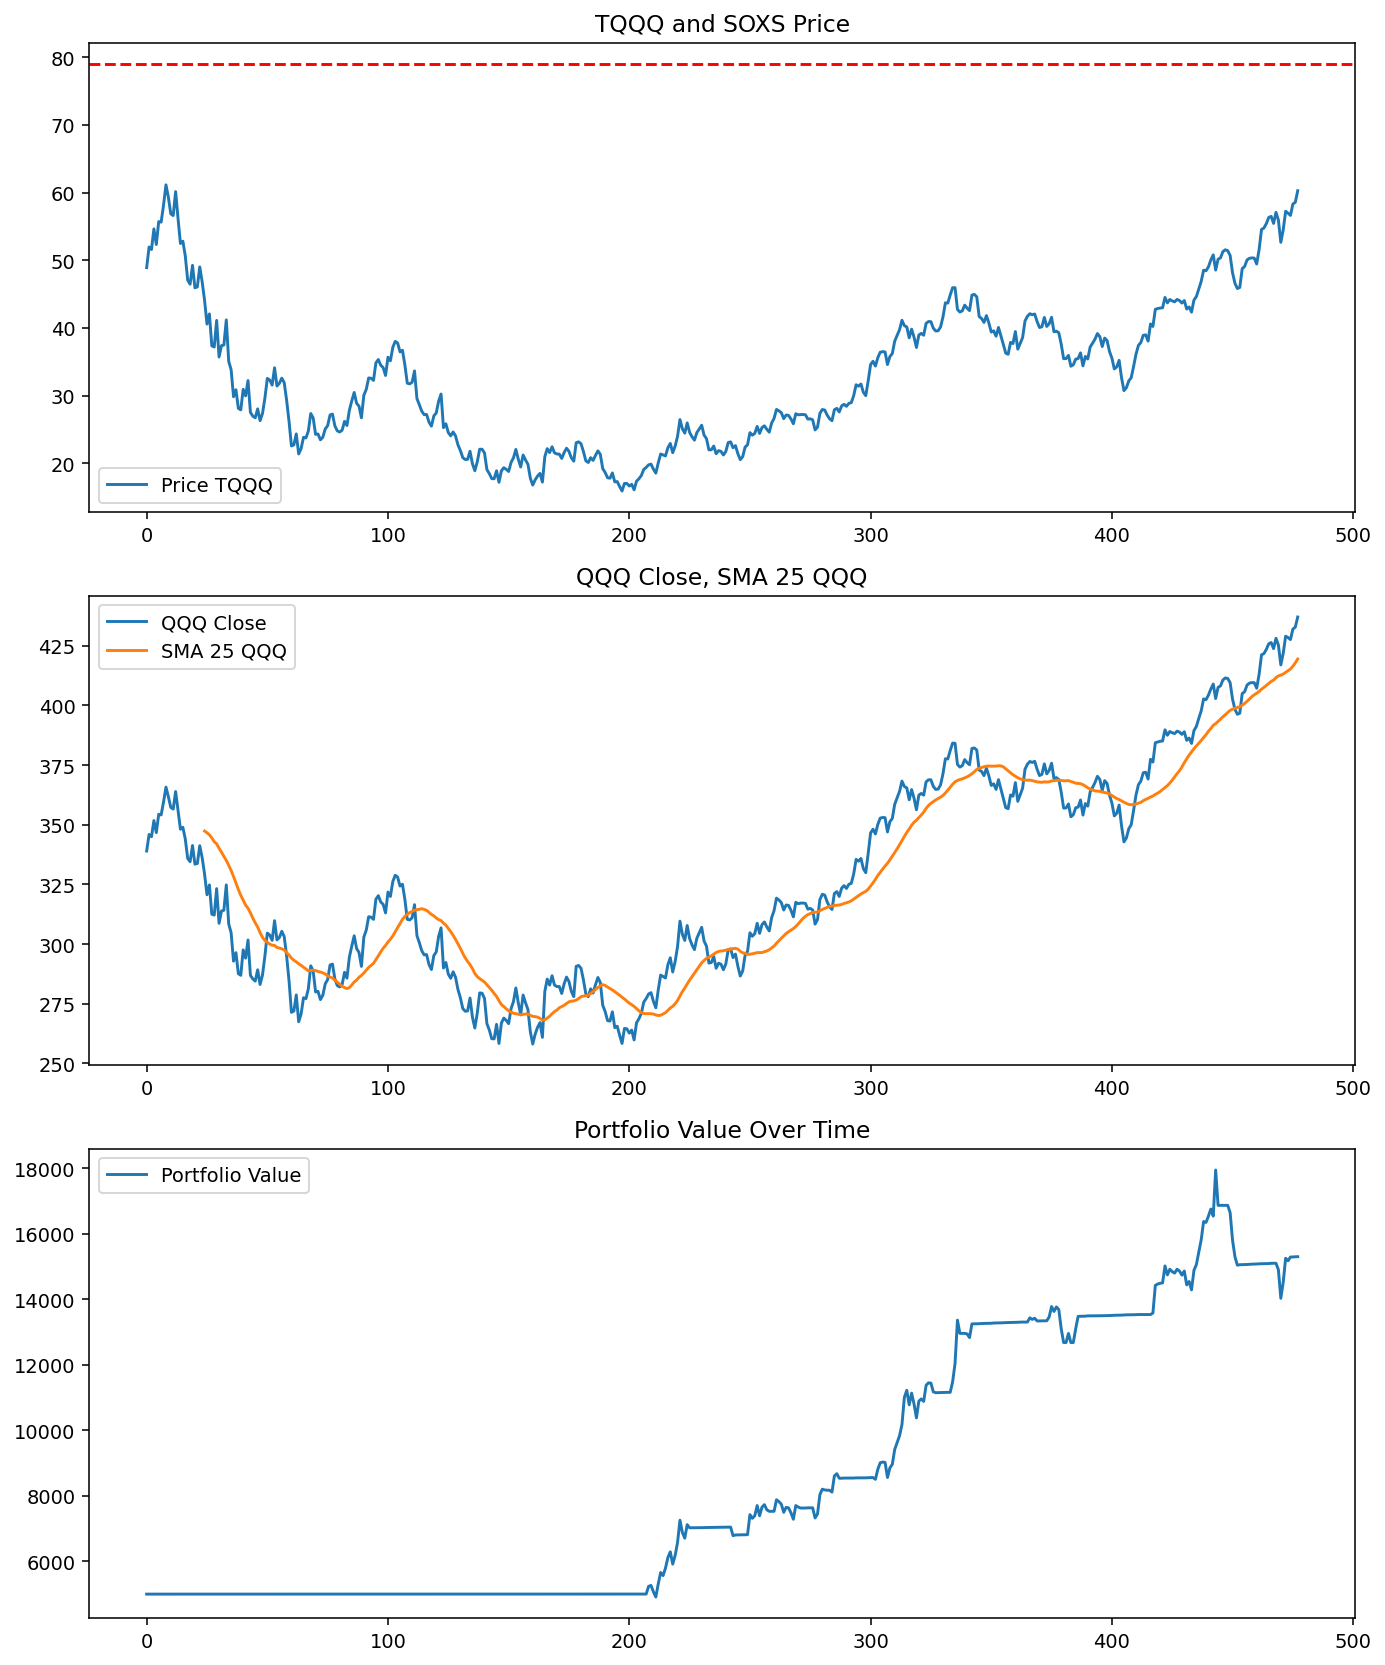

In [ ]:
def execute_historical_backtestandpaper_TQQQ_or_not():
    # Calculate the start date based on the period
    days = int(290) #ensure that days is an integer
    end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    #end_date = convert_date_format("2021-01-01")
    #start_date = end_date - timedelta(days=days)
    start_date = convert_date_format("2023-01-01")- timedelta(days=days)
    print('start_date :', start_date.isoformat() )
    print('end_date :', end_date.isoformat() )

    # Format dates in RFC-3339 format, removing microseconds
    start_date = start_date.replace(microsecond=0).isoformat() + 'Z'  # Append 'Z' to indicate UTC
    end_date = end_date.replace(microsecond=0).isoformat() + 'Z'

    # Retrieve the data
    run_backtest(TQQQ_or_not, ['SOXS' , 'TQQQ', 'UVXY', 'BIL', 'BND', 'QQQ', 'SPY', 'IEF', 'TMF', 'TLT' ], start_date, end_date, TimeFrame.Day, 5000)

execute_historical_backtestandpaper_TQQQ_or_not()